In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

import os
import io

import datetime

%load_ext tensorboard

2022-11-04 01:42:55.522351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 01:42:55.622541: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 01:42:56.039096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/simon/anaconda3/envs/tf/lib/
2022-11-04 01:42:56.039143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

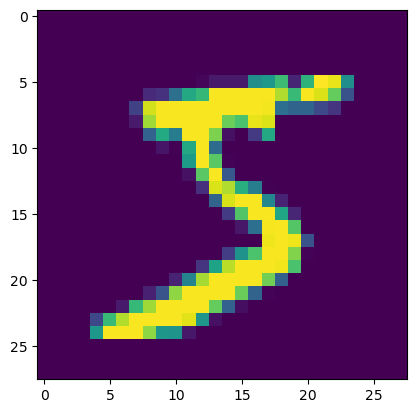

In [2]:
(X_train, Y_train), _ = mnist.load_data()
X_train = (X_train - 127.5) / 127.5
plt.imshow(X_train[0,:,:])

In [3]:
def make_generator(latent_vector_shape):
    latent_input = layers.Input(shape=latent_vector_shape)
    gen = layers.Dense(3*3*latent_vector_shape)(latent_input)
    gen = layers.Reshape((3,3,latent_vector_shape))(gen)
    gen = layers.Dropout(0.2)(gen)
    
    label_input = layers.Input((1,), name="label")
    label = layers.Embedding(10, 50)(label_input)
    label = layers.Dense(3*3)(label)
    label = layers.Reshape((3,3,1))(label)
    
    gan = layers.Concatenate()([gen, label])
    
    gen = layers.Conv2DTranspose(latent_vector_shape, (2, 2), 2, use_bias=False)(gen)
    gen = layers.ReLU()(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.Dropout(0.4)(gen)
    #Output: (7, 7, lvs)
    
    gen = layers.Conv2DTranspose(latent_vector_shape/2, (4, 4), 2, use_bias=False)(gen)
    gen = layers.ReLU()(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.Dropout(0.4)(gen)
    #Output: (14, 14, lvs/2)
    
    gen = layers.Conv2DTranspose(latent_vector_shape/4, (4, 4), 2, use_bias=False)(gen)
    gen = layers.ReLU()(gen)
    gen = layers.BatchNormalization()(gen)
    gen = layers.Dropout(0.4)(gen)
    #Output: (28, 28, lvs/4)
    
    out = layers.Conv2D(1, (3, 3), strides=(1,1), activation='tanh')(gen)
    
    model: keras.Model = keras.Model([latent_input, label_input], out)
    print(model.output_shape)
    assert model.output_shape == (None, 28, 28, 1)
    return model

generator = make_generator(128)
generator.summary()

(None, 28, 28, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 1152)         148608      ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 3, 3, 128)    0           ['dense[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 3, 3, 128)    0           ['reshape[0][0]']                
                                                                            

2022-11-04 01:42:57.563089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 01:42:57.566879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 01:42:57.567001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 01:42:57.567462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
def make_discriminator(input_shape):
    image_input = layers.Input(input_shape)
    
    label_input = layers.Input((1,), name="label")
    label = layers.Embedding(10, 50)(label_input)
    label = layers.Dense(28*28)(label)
    label = layers.Reshape((28,28,1))(label)
    
    disc = layers.Concatenate()([image_input, label])
    
    disc = layers.Conv2D(32, (3, 3))(disc)
    disc = layers.AveragePooling2D()(disc)
    disc = layers.LeakyReLU(alpha=0.02)(disc)
    disc = layers.BatchNormalization()(disc)
    
    disc = layers.Conv2D(64, (3, 3))(disc)
    disc = layers.AveragePooling2D()(disc)
    disc = layers.LeakyReLU(alpha=0.02)(disc)
    disc = layers.Dropout(0.3)(disc)
    
    disc = layers.Conv2D(64, (3, 3))(disc)
    disc = layers.AveragePooling2D()(disc)
    disc = layers.LeakyReLU(alpha=0.02)(disc)
    disc = layers.Dropout(0.3)(disc)
    
    disc = layers.Flatten()(disc)
    disc = layers.Dropout(0.3)(disc)
    disc = layers.Dense(30)(disc)
    out = layers.Dense(1, activation='sigmoid')(disc)
    
    model = keras.Model([image_input, label_input], out)
    
    return model

discriminator = make_discriminator((28, 28, 1))
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['label[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1, 784)       39984       ['embedding_1[0][0]']            
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                            

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim=128, disc_extra_steps=3):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = disc_extra_steps
        self.noiseLayer = layers.GaussianNoise(0.3)
        
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, data):
        images, labels = data
        batch_size = tf.shape(images)[0]
        
        for i in range(self.d_steps):
            latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_labels = tf.random.uniform(shape=(batch_size, 1), minval=0,maxval=10, dtype='int32')
            with tf.GradientTape() as gt:
                generated_images = self.generator([latent_vector, generated_labels], training=True)
                noisy_generated_images = self.noiseLayer(generated_images, training=False) 
                prediction_fake = self.discriminator([generated_images, generated_labels], training=True)
                
                noisy_images = self.noiseLayer(images, training=False)
                prediction_real = self.discriminator([noisy_images, labels], training=True)
                
                d_loss = self.d_loss_fn(prediction_real, prediction_fake)
            d_gradients = gt.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
            
            for i in range(3):
                latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
                generated_labels = tf.random.uniform(shape=(batch_size, 1), minval=0,maxval=10, dtype='int32')
                with tf.GradientTape() as gt:
                    generated_images = self.generator([latent_vector, generated_labels], training=True)
                    prediction_fake = self.discriminator([generated_images, generated_labels], training=True)
                    g_loss = self.g_loss_fn(prediction_fake)

                g_gradients = gt.gradient(g_loss, self.generator.trainable_variables)
                self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
            
        return {"d_loss": d_loss, "g_loss": g_loss}

In [6]:
cross_entropy = keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
log_dir = "mnistCGAN/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
img_log_dir = "mnistCGAN/logs/images/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

file_writer = tf.summary.create_file_writer(img_log_dir)

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=16, latent_dim=100):
        self.num_img = num_img
        self.seed = random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
        self.label_seed = tf.random.uniform(shape=(num_img, 1), minval=0,maxval=10, dtype='int32')
    
    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator([self.seed, self.label_seed], training=False)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images = generated_images.numpy()
        
        fig = plt.figure(figsize=(4, 4))
    
        for i in range(generated_images.shape[0]):
            axs = fig.add_subplot(4, 4, i+1)
            axs.imshow(generated_images[i, :, :, :].astype("int32"))
            axs.set_title(self.label_seed.numpy()[i][0],)
            axs.axis('off')
        fig.tight_layout()
        plt.savefig(os.path.join("mnistCGAN/", "images/",'image_at_epoch_{:04d}.png'.format(epoch)))
        with file_writer.as_default():
            tf.summary.image("Output", plot_to_image(fig), step=epoch)

ick = GANMonitor(num_img=16, latent_dim=128)


In [8]:
gan = GAN(discriminator, generator, disc_extra_steps=1)
gan.compile(discriminator_optimizer, generator_optimizer, discriminator_loss, generator_loss)

In [9]:
%tensorboard --logdir mnistCGAN/logs
gan.fit(X_train, Y_train, epochs=50, batch_size=256, callbacks=[ick, tensorboard_callback])

Epoch 1/50


2022-11-04 01:43:03.636544: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-04 01:43:03.982720: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


235/235 [==============================] - 16s 50ms/step - d_loss: 0.9582 - g_loss: 1.1309
Epoch 2/50
235/235 [==============================] - 11s 48ms/step - d_loss: 1.0595 - g_loss: 1.1674
Epoch 3/50
235/235 [==============================] - 12s 50ms/step - d_loss: 0.8930 - g_loss: 1.4158
Epoch 4/50
235/235 [==============================] - 12s 49ms/step - d_loss: 0.7134 - g_loss: 1.9883
Epoch 5/50
235/235 [==============================] - 11s 48ms/step - d_loss: 0.5593 - g_loss: 2.6329
Epoch 6/50
235/235 [==============================] - 12s 49ms/step - d_loss: 0.3391 - g_loss: 3.8003
Epoch 7/50
235/235 [==============================] - 11s 48ms/step - d_loss: 0.1210 - g_loss: 5.5274
Epoch 8/50
235/235 [==============================] - 12s 49ms/step - d_loss: 0.0515 - g_loss: 6.8296
Epoch 9/50
235/235 [==============================] - 12s 50ms/step - d_loss: 0.0271 - g_loss: 7.8023
Epoch 10/50
235/235 [==============================] - 12s 50ms/step - d_loss: 0.0177 - g_los

KeyboardInterrupt: 

In [ ]:
images = 25
predictions = np.empty([100,28,28,1])
for i in range(4):
    seed = tf.random.normal([images, 128])
    label_seed = np.random.randint(0,2, images)
    pred = generator(seed, training=False).numpy()
    predictions[25*i:25*(i+1), :, :, :] = pred
    
print(predictions.shape)
figsize = 10
fig = plt.figure(figsize=(figsize, figsize))  
for i in range(predictions.shape[0]):
    plt.subplot(figsize, figsize, i+1)
    plt.imshow((predictions[i, :, :, :]*127.5+127.5).astype("int32"))
    plt.axis('off')
plt.show()